# DV8 standard deviation

In [2]:
import xarray as xr
import numpy as np
import pandas as pd
import dask
import cartopy.feature as cfeature
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import intake
import cartopy.crs as ccrs
from tempfile import TemporaryDirectory
from getpass import getuser
from pathlib import Path
from dask.distributed import Client, LocalCluster
import subprocess
import re

import warnings
warnings.filterwarnings('ignore')

In [3]:

import dask
from dask.distributed import Client, LocalCluster
import bokeh

dask.config.config.get('distributed').get('dashboard').update({'link':'{JUPYTERHUB_SERVICE_PREFIX}/proxy/{port}/status'})
cluster = LocalCluster(n_workers=32, threads_per_worker=4)
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/b382616/levante-spawner-preset//proxy/8787/status,
Dashboard: /user/b382616/levante-spawner-preset//proxy/8787/status,Workers: 32
Total threads: 128,Total memory: 235.37 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:38827,Workers: 32
Dashboard: /user/b382616/levante-spawner-preset//proxy/8787/status,Total threads: 128
Started: Just now,Total memory: 235.37 GiB
Comm: tcp://127.0.0.1:46741,Total threads: 4
Dashboard: /user/b382616/levante-spawner-preset//proxy/32847/status,Memory: 7.36 GiB
Nanny: tcp://127.0.0.1:32933,


# SST

In [24]:
cat = intake.open_catalog("https://raw.githubusercontent.com/eerie-project/intake_catalogues/main/eerie.yaml")
expid = 'eerie-control-1950'
version = 'v20231106'
model = 'icon-esm-er'
gridspec = 'gr025'

dat = cat['dkrz.disk.model-output'][model][expid][version]['ocean'][gridspec]

In [25]:
da_predictor = dat['2d_daily_mean'](chunks={}).to_dask().to.isel(depth=0).drop('depth')
sst = dat['2d_daily_mean'](chunks={'time':da_predictor.chunks[0]}).to_dask().to.isel(depth=0).drop('depth')
sst['lon'] = np.mod(sst['lon'] + 180, 360) - 180
sst = sst.sortby(sst['lon'])
sst

<xarray.DataArray 'to' (time: 13879, lat: 721, lon: 1440)> Size: 58GB
dask.array<getitem, shape=(13879, 721, 1440), dtype=float32, chunksize=(1, 182, 1440), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 6kB -90.0 -89.75 -89.5 -89.25 ... 89.5 89.75 90.0
  * time     (time) datetime64[ns] 111kB 2002-01-01T23:59:00 ... 2039-12-31T2...
  * lon      (lon) float64 12kB -180.0 -179.8 -179.5 ... 179.2 179.5 179.8
Attributes:
    code:           2
    long_name:      sea water potential temperature
    standard_name:  sea_water_potential_temperature
    units:          deg C

In [23]:
sst_std = sst.std(dim="time")

In [7]:
sst_std = sst_std.compute()

/home/b/b382616/.local/lib/python3.9/site-packages/dask/array/numpy_compat.py:56: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)


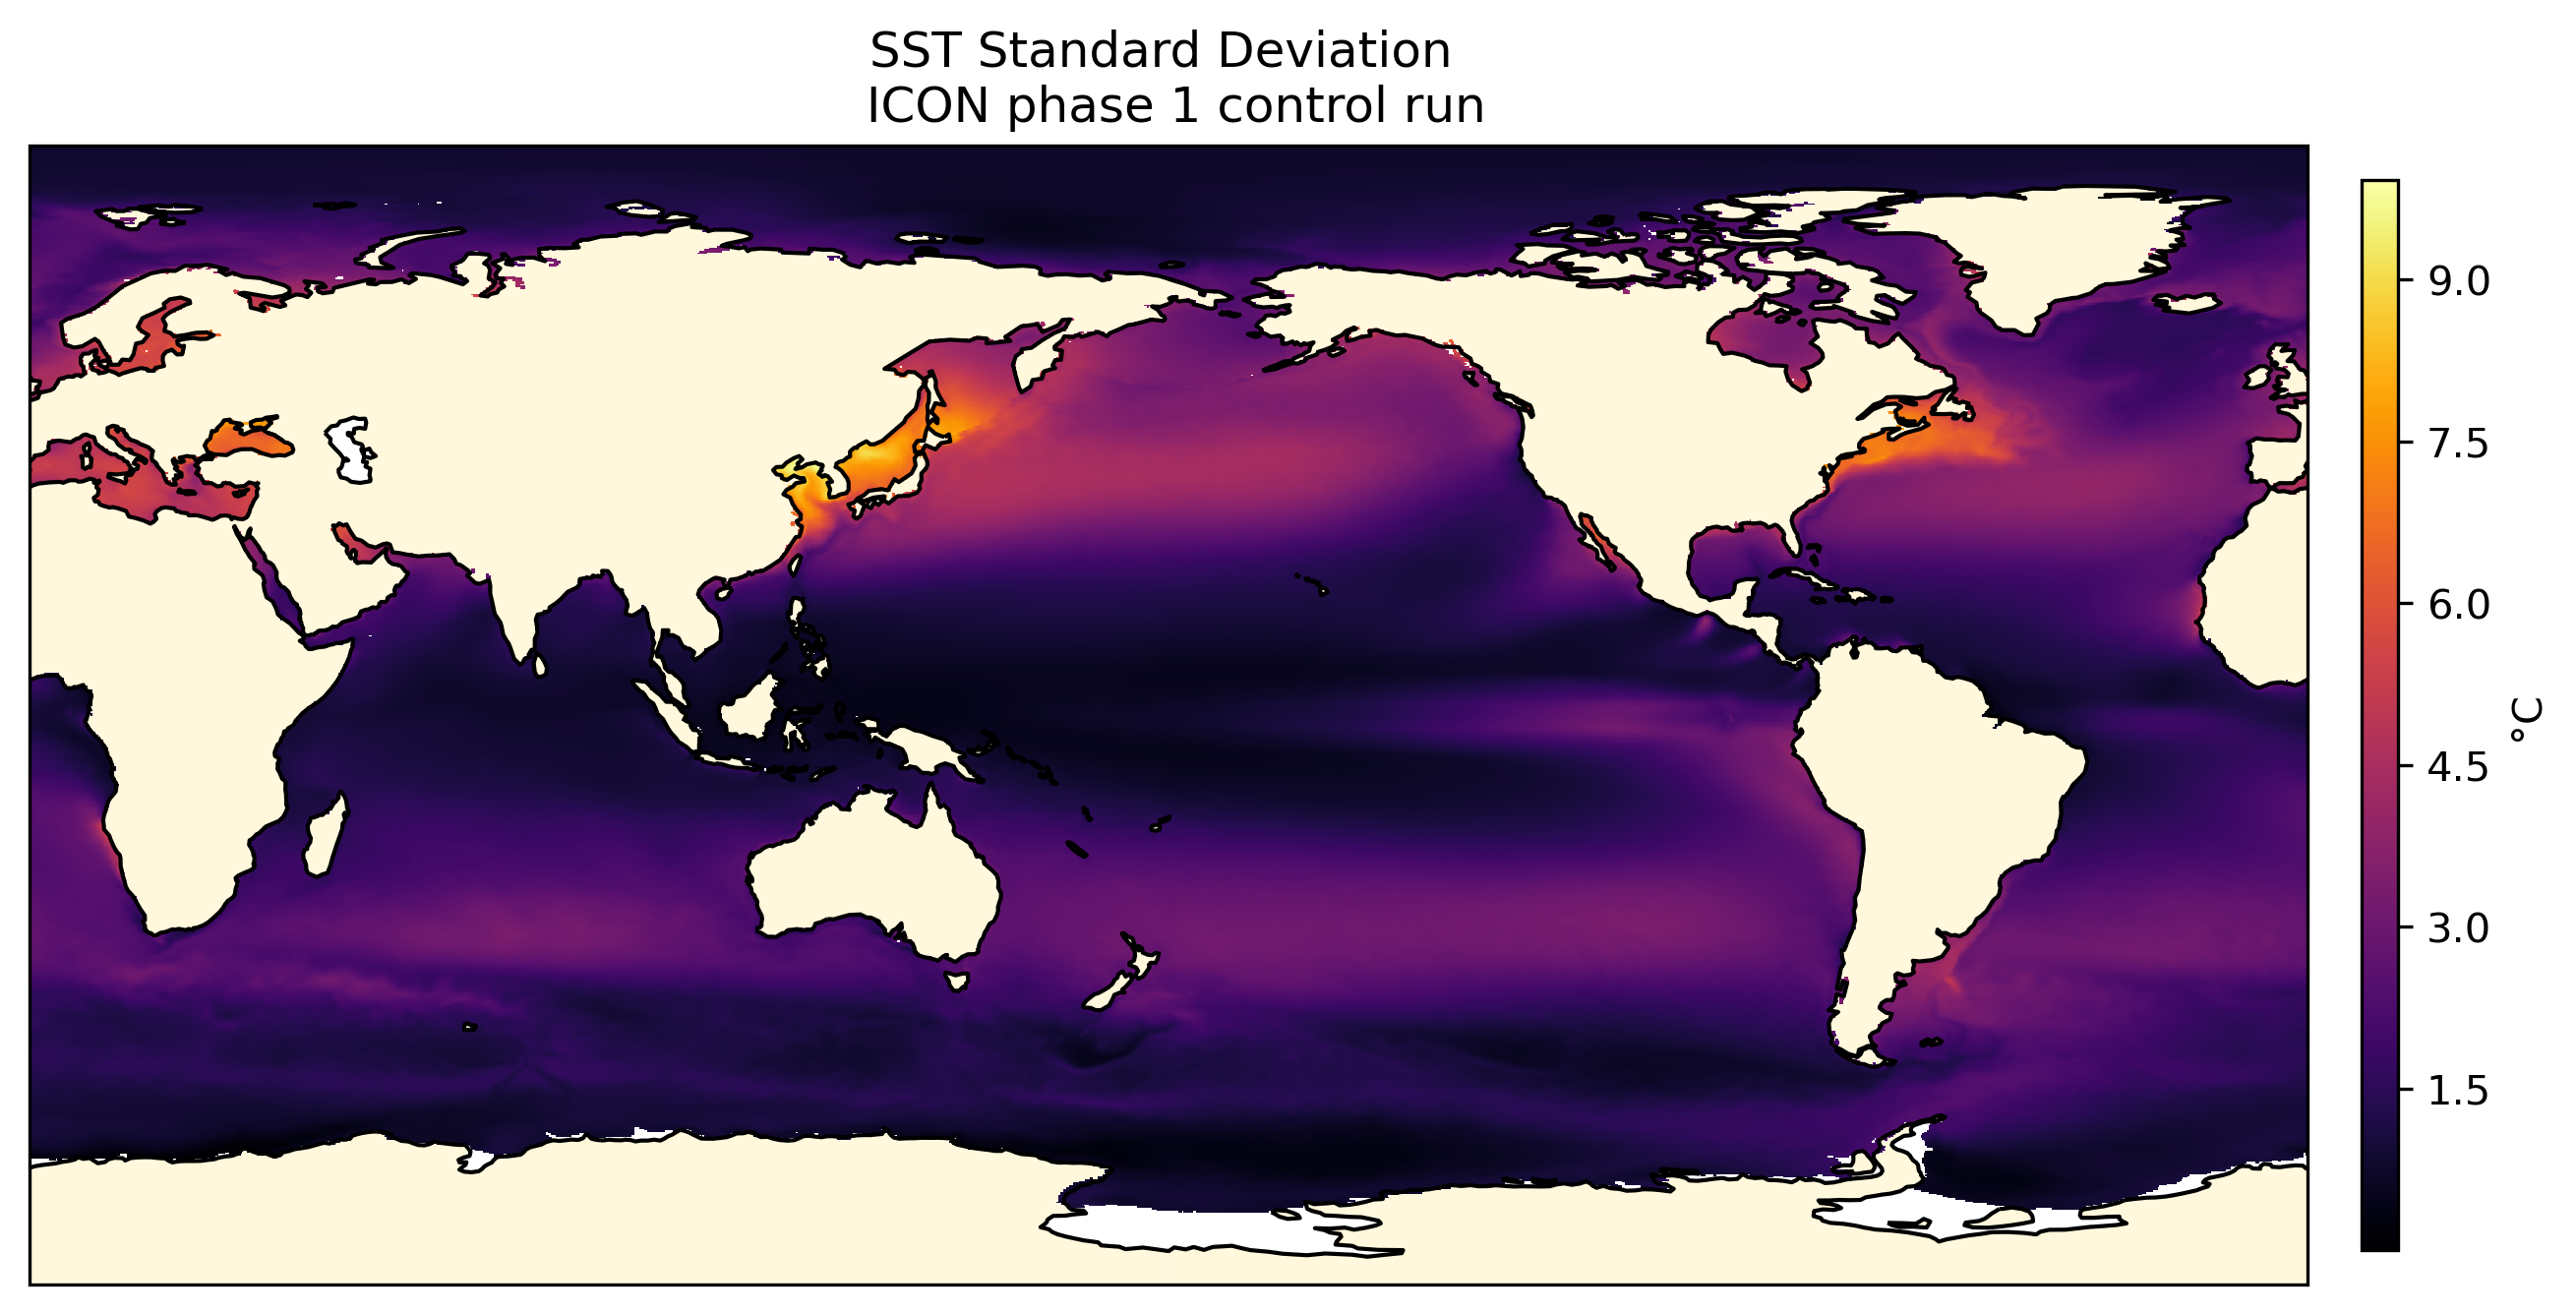

In [35]:


fig = plt.figure(figsize=(12, 6),dpi=300)
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))  
ax.set_global()  
ax.add_feature(cfeature.LAND, facecolor='cornsilk')

ax.coastlines()
pcm = ax.pcolormesh(sst_std.lon, sst_std.lat, sst_std, cmap='inferno', transform=ccrs.PlateCarree())


cbar = fig.colorbar(pcm, ax=ax, orientation="vertical", shrink=0.8, pad=0.02, aspect=30)

# Increase the number of ticks
cbar.set_ticks(ticker.MaxNLocator(nbins=8))  # Adjust nbins as needed

cbar.set_label("°C")

# Title
plt.title("SST Standard Deviation \n ICON phase 1 control run")

plt.show()


In [24]:
np.nanmax(sst_std)

/home/b/b382616/.local/lib/python3.9/site-packages/dask/array/numpy_compat.py:56: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/home/b/b382616/.local/lib/python3.9/site-packages/dask/array/numpy_compat.py:56: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/home/b/b382616/.local/lib/python3.9/site-packages/dask/array/numpy_compat.py:56: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/home/b/b382616/.local/lib/python3.9/site-packages/dask/array/numpy_compat.py:56: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)


9.921022

# SSTA

In [26]:
file_name = Path('/scratch') / getuser()[0] / getuser() / 'mhws' / 'extreme_events_binary_ord2.zarr'
chunk_size = {'time': 25, 'lat': -1, 'lon': -1}
ds = xr.open_zarr(str(file_name), chunks=chunk_size)
ssta=ds['dat_detrend']

In [27]:
ssta=ds['dat_detrend']

In [8]:
len(ssta)

13879

In [7]:
ssta_std = ssta.std(dim="time")
ssta_std

<xarray.DataArray 'dat_detrend' (lat: 721, lon: 1440)> Size: 8MB
dask.array<_sqrt, shape=(721, 1440), dtype=float64, chunksize=(721, 1440), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 6kB -90.0 -89.75 -89.5 -89.25 ... 89.5 89.75 90.0
  * lon      (lon) float64 12kB 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8

In [8]:
ssta_std=ssta_std.compute()

/home/b/b382616/.local/lib/python3.9/site-packages/dask/array/numpy_compat.py:56: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)


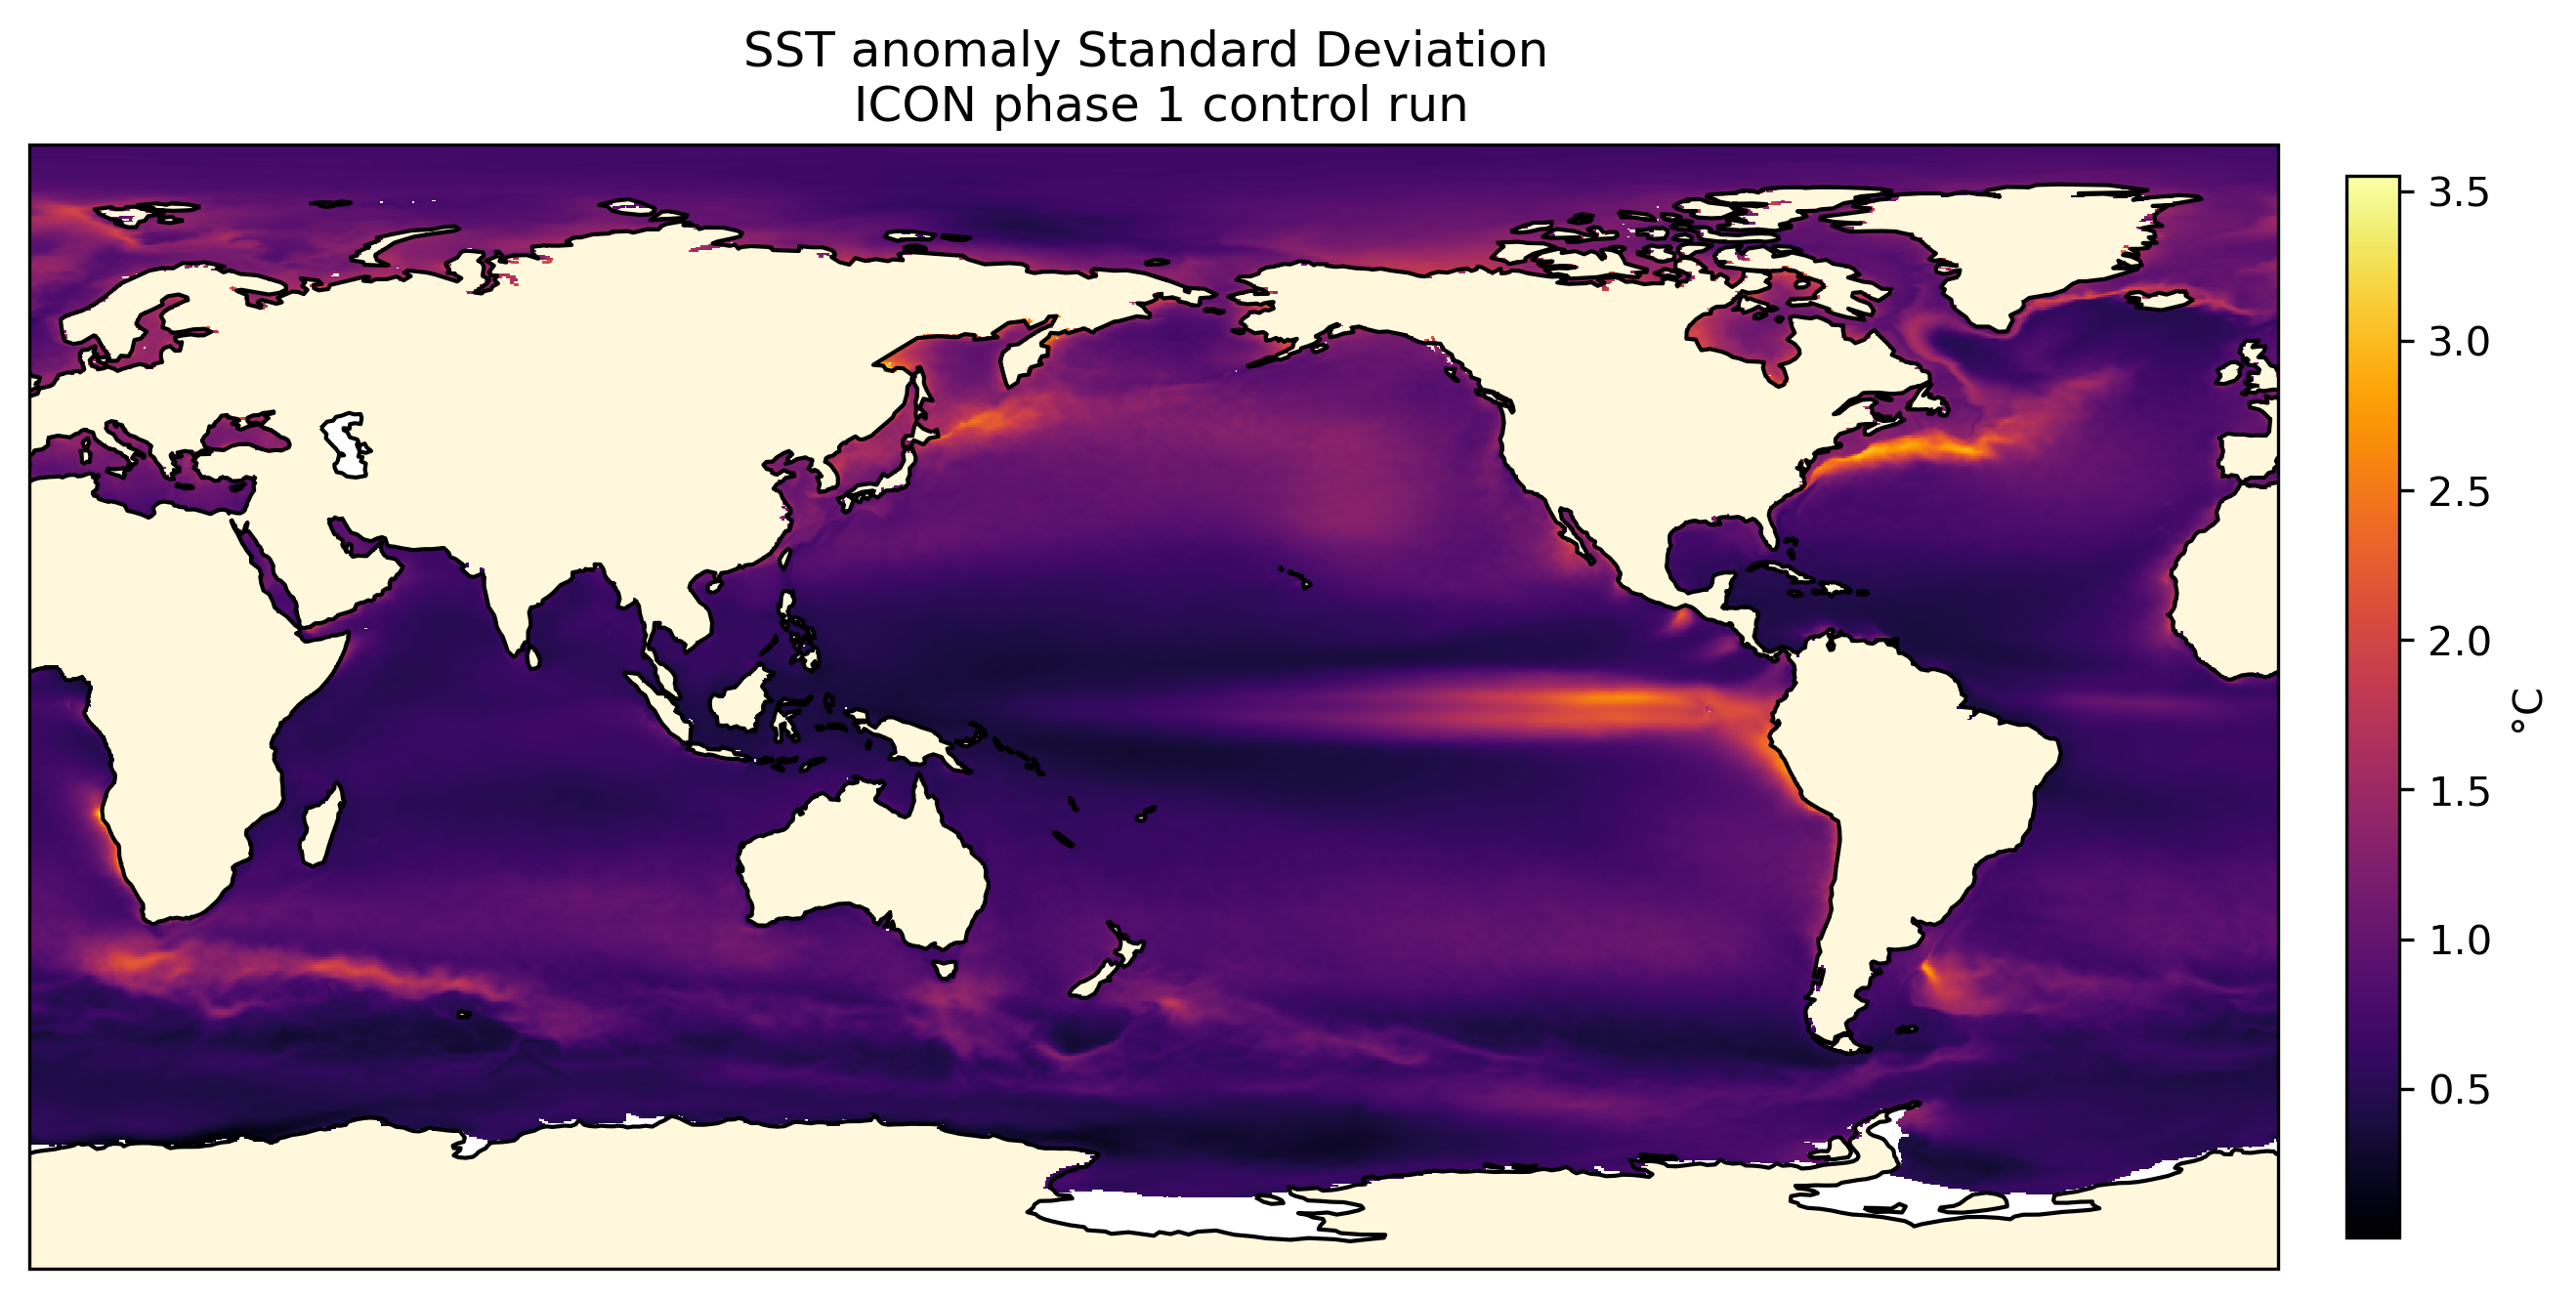

In [13]:


fig = plt.figure(figsize=(12, 6),dpi=300)
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))  
ax.set_global()  
ax.add_feature(cfeature.LAND, facecolor='cornsilk')

ax.coastlines()
pcm = ax.pcolormesh(ssta_std.lon, ssta_std.lat, ssta_std, cmap='inferno', transform=ccrs.PlateCarree())


cbar = fig.colorbar(pcm, ax=ax, orientation="vertical", shrink=0.8, pad=0.025)#, aspect=3)

# Increase the number of ticks
cbar.set_ticks(ticker.MaxNLocator(nbins=8))  # Adjust nbins as needed

cbar.set_label("°C")

# Title
plt.title("SST anomaly Standard Deviation \n ICON phase 1 control run")

plt.show()


In [9]:
ssta_mean=ssta.mean(dim='time')
ssta_mean=ssta_mean.compute()

In [14]:
ssta_mean.max()

NameError: name 'ssta_mean' is not defined

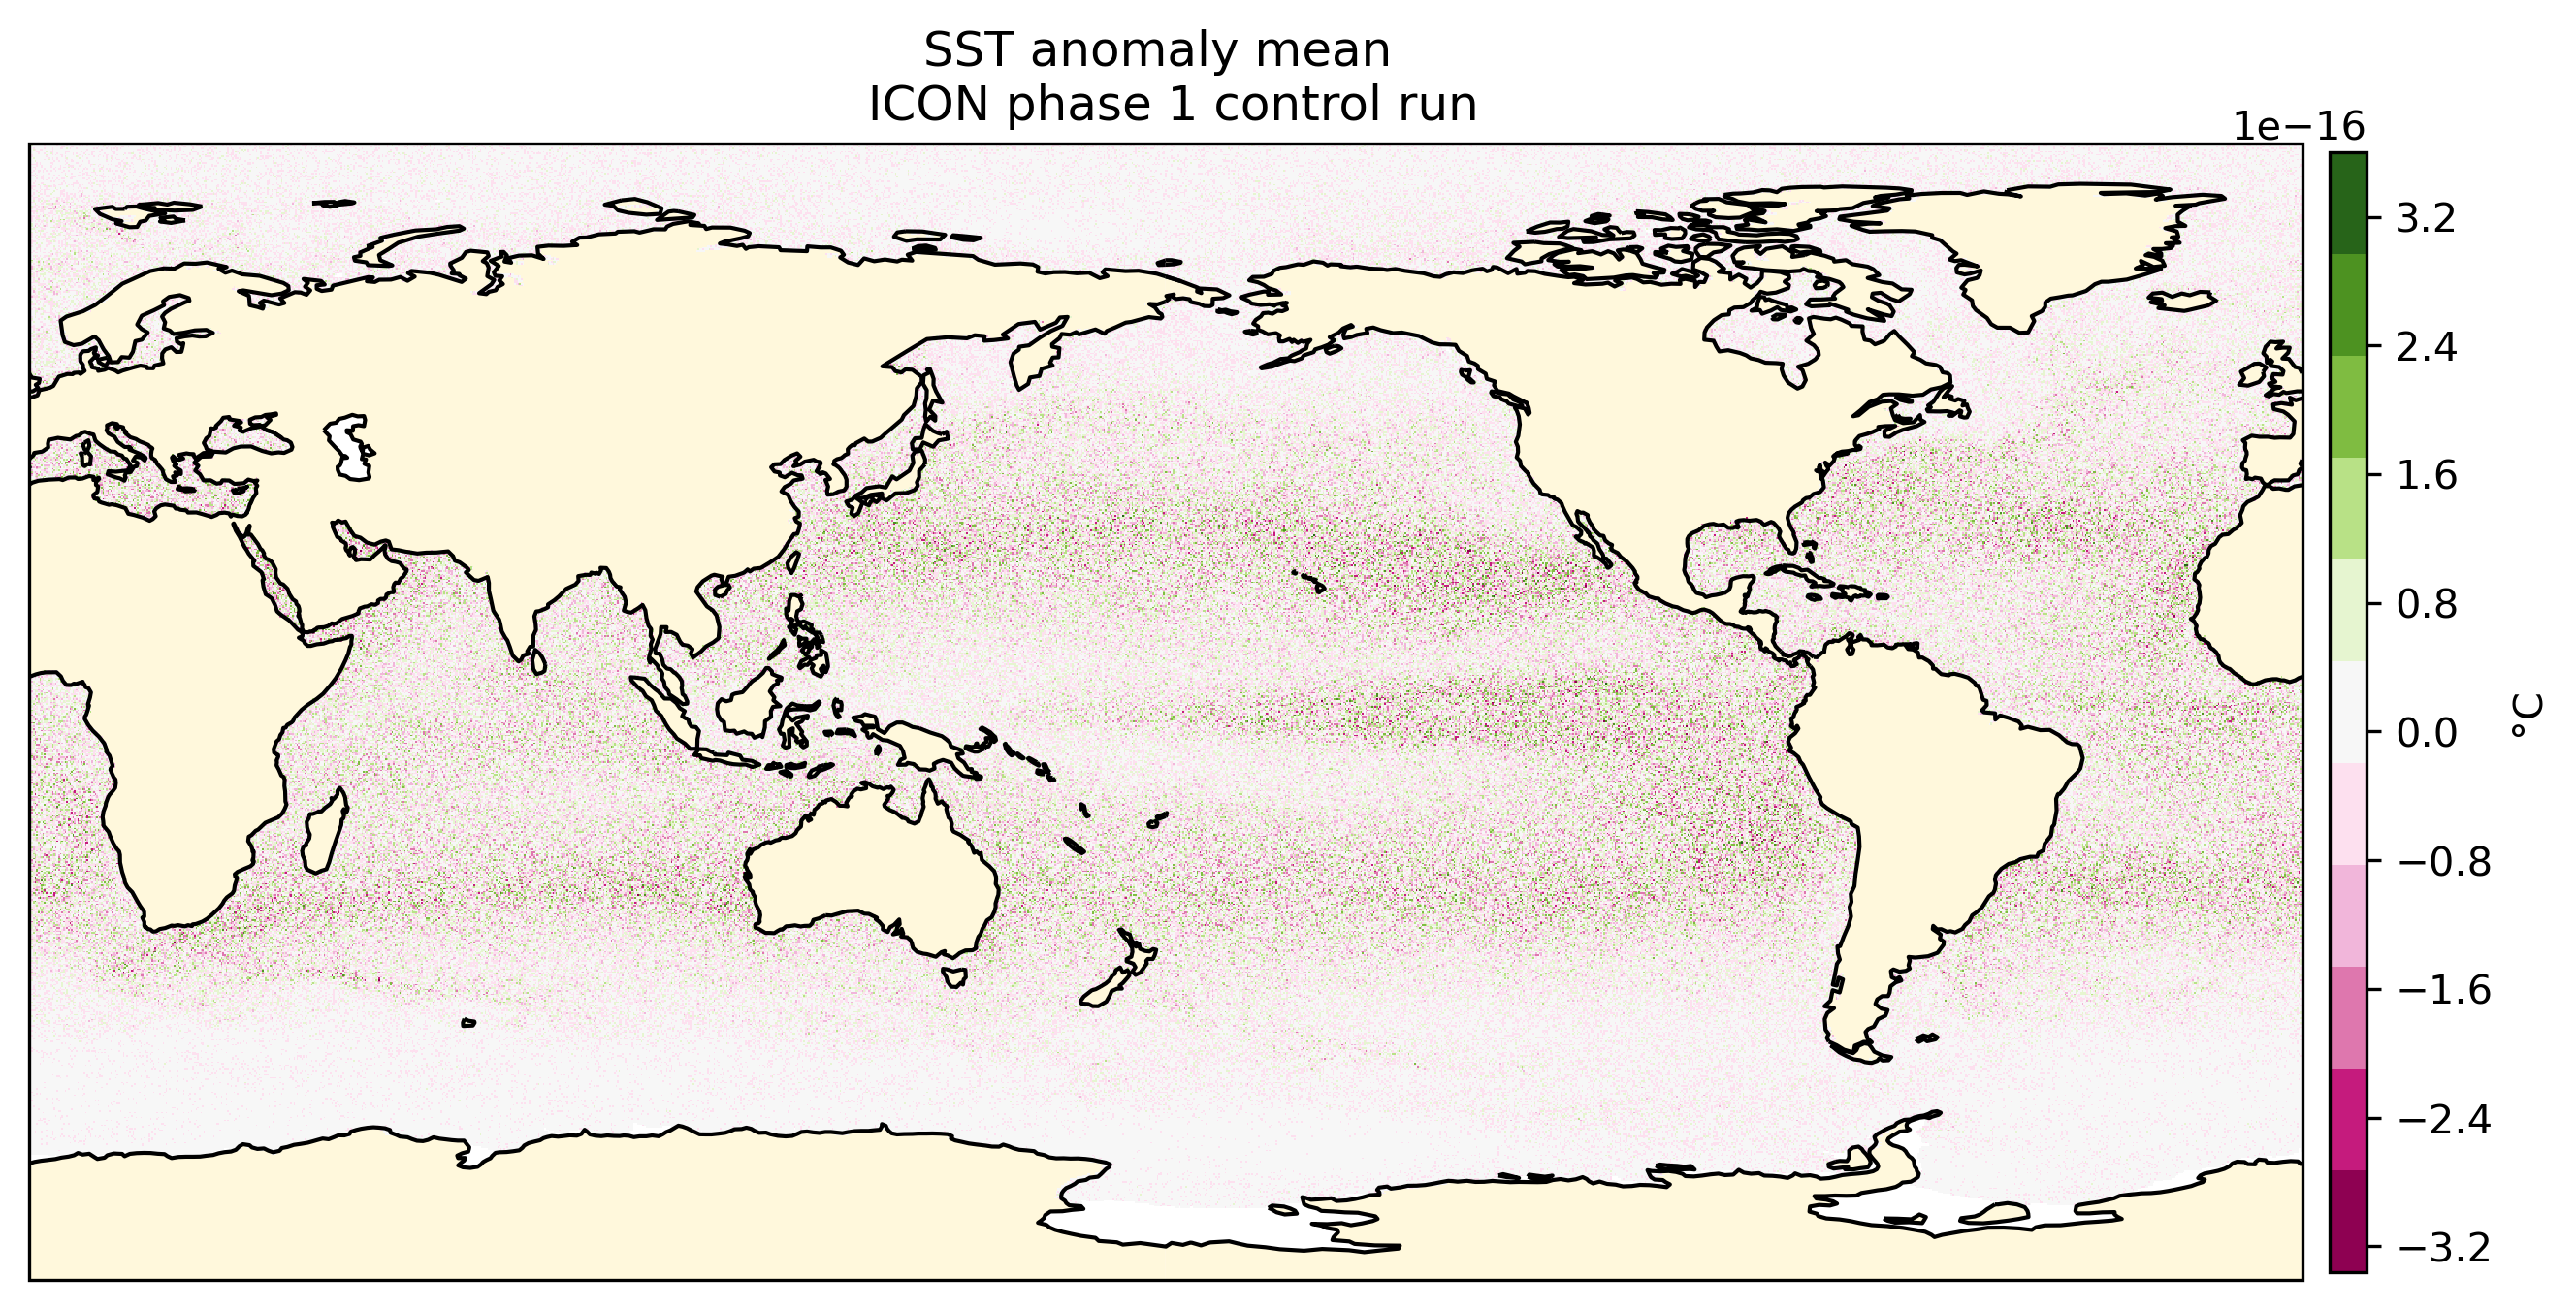

In [20]:


fig = plt.figure(figsize=(12, 6),dpi=300)
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))  
ax.set_global()  
ax.add_feature(cfeature.LAND, facecolor='cornsilk')
cmap = plt.get_cmap('PiYG', 11) 
ax.coastlines()
pcm = ax.pcolormesh(ssta_mean.lon, ssta_mean.lat, ssta_mean, cmap=cmap, transform=ccrs.PlateCarree())


cbar = fig.colorbar(pcm, ax=ax, orientation="vertical", shrink=0.85, pad=0.01, aspect=30)

# Increase the number of ticks
cbar.set_ticks(ticker.MaxNLocator(nbins=10))  # Adjust nbins as needed

cbar.set_label("°C")

# Title
plt.title("SST anomaly mean \n ICON phase 1 control run")

plt.show()


In [28]:
# Example: Global SSTA 
global_anom = ssta.mean(dim=['lat', 'lon'])

# AMV Region 
#amv_anom = ssta.sel(lat=slice(0, 65), lon=slice(105, 172.5)).mean(dim=['lat', 'lon'])

# Gulf Stream Region (customize coordinates)
gulf_stream_anom = ssta.sel(lat=slice(25, 50), lon=slice(100, 125)).mean(dim=['lat', 'lon'])

Agulhas_an=ssta.sel(lat=slice(-40,-25),lon=slice(195,225)).mean(dim=['lat', 'lon'])

Kuroshio_an=ssta.sel(lat=slice(25,40),lon=slice(310,330)).mean(dim=['lat', 'lon'])


In [29]:
global_anom=global_anom.compute()

In [9]:
gulf_stream_anom=gulf_stream_anom.compute()
#amv_anom=amv_anom.compute()
global_anom=global_anom.compute()
Kuroshio_an=Kuroshio_an.compute()
Agulhas_an=Agulhas_an.compute()

2025-02-26 14:24:02,955 - distributed.scheduler - WARNING - Detected different `run_spec` for key 'original-open_dataset-dat_detrend-f4061c3c723685e87c5542ac04b194e1' between two consecutive calls to `update_graph`. This can cause failures and deadlocks down the line. Please ensure unique key names. If you are using a standard dask collections, consider releasing all the data before resubmitting another computation. More details and help can be found at https://github.com/dask/dask/issues/9888. 
Debugging information
---------------------
old task state: released
old run_spec: (<function execute_task at 0x7fff0e89f160>, (ImplicitToExplicitIndexingAdapter(array=CopyOnWriteArray(array=LazilyIndexedArray(array=<xarray.backends.zarr.ZarrArrayWrapper object at 0x7ffd3f8523c0>, key=BasicIndexer((slice(None, None, None), slice(None, None, None), slice(None, None, None)))))),), {})
new run_spec: (<function execute_task at 0x7fff0e89f160>, (ImplicitToExplicitIndexingAdapter(array=CopyOnWriteArr

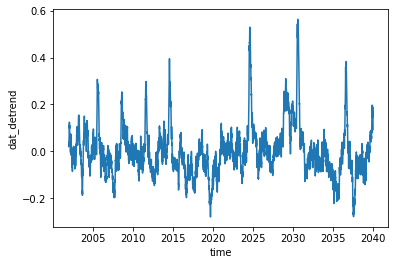

In [19]:
ds['dat_detrend'].mean(dim={'lat','lon'}).plot()

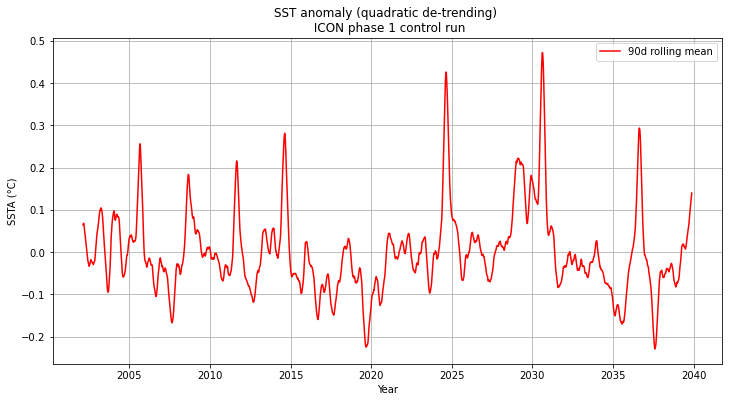

In [33]:

plt.figure(figsize=(12, 6))

# SSTA
#plt.plot(ssta['time'], global_anom, color='red', alpha=1, label='Global Raw')

# Smoothed data (black)
global_smooth = global_anom.rolling(time=90, center=True).mean()
plt.plot(ssta['time'], global_smooth, color='red', linewidth=1.5, label='90d rolling mean')

# AMV (blue)
#amv_smooth = amv_anom.rolling(time=90, center=True).mean()
#plt.plot(ssta['time'], amv_smooth, color='blue', linewidth=1.5, label='AMV')

#gulf stream
#gulf_stream_anom_smooth = gulf_stream_anom.rolling(time=90, center=True).mean()
#plt.plot(ssta['time'], gulf_stream_anom_smooth, color='red', linewidth=1.5, label='Gulf Stream')

#gulf stream
#Agulhas_an_smooth = Agulhas_an.rolling(time=90, center=True).mean()
#plt.plot(ssta['time'], Agulhas_an_smooth, color='purple', linewidth=1.5, label='Agulhas current')

#gulf stream
#Kuroshio_an_anom_smooth = Kuroshio_an.rolling(time=90, center=True).mean()
#plt.plot(ssta['time'], Kuroshio_an_anom_smooth, color='red', linewidth=1.5, label='Kuroshio current')

# Add other regions (NINO 3.4, NE Pacific, Gulf Stream, etc.)
plt.xlabel('Year')
plt.ylabel('SSTA (°C)')
plt.title('SST anomaly (quadratic de-trending) \n ICON phase 1 control run')
plt.legend()
plt.grid(True)
plt.show()

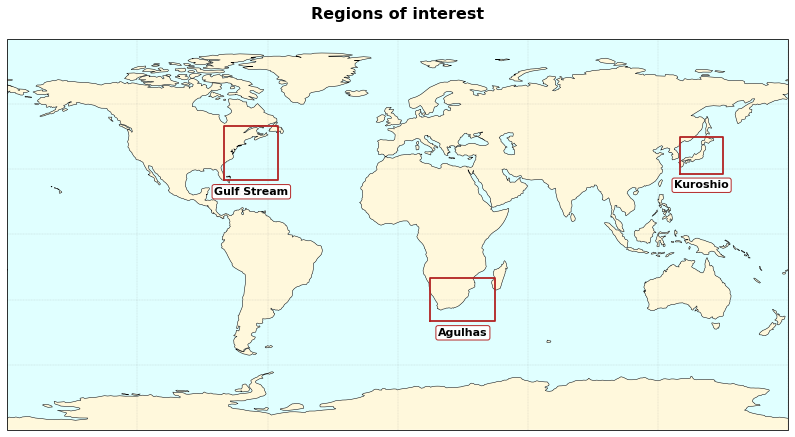

In [118]:

# Define regions of interest with bounding boxes
regions = {
    'Gulf Stream': {'lon': (-80, -55), 'lat': (25, 50)},
    'Agulhas': {'lon': (15, 45), 'lat': (-40, -20)},
    'Kuroshio': {'lon': (130, 150), 'lat': (28, 45)}
}

# Create figure and axis
fig = plt.figure(figsize=(14, 8))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

# Add map features
ax.add_feature(cfeature.LAND, facecolor='cornsilk')
ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax.add_feature(cfeature.OCEAN, facecolor='lightcyan')

# Plot regions with labels below
for name, box in regions.items():
    # Draw rectangle
    ax.plot(
        [box['lon'][0], box['lon'][1], box['lon'][1], box['lon'][0], box['lon'][0]],
        [box['lat'][0], box['lat'][0], box['lat'][1], box['lat'][1], box['lat'][0]],
        color='firebrick', linewidth=1.8, transform=ccrs.PlateCarree()
    )
    
    # Calculate label position (centered below rectangle)
    label_lon = np.mean(box['lon'])
    label_lat = box['lat'][0] - 3  # 3 degrees below southern boundary
    
    # Add label
    ax.text(
        label_lon,
        label_lat,
        name,
        horizontalalignment='center',
        verticalalignment='top',
        transform=ccrs.PlateCarree(),
        fontsize=11,
        fontweight='bold',
        bbox=dict(
            facecolor='white', 
            alpha=0.95,
            boxstyle='round,pad=0.2',
            edgecolor='firebrick'
        )
    )

# Set global extent and add subtle grid
ax.set_global()
ax.gridlines(linewidth=0.3, color='gray', linestyle='--', alpha=0.5)

# Title
plt.title('Regions of interest', fontsize=16, pad=20, fontweight='bold')

plt.show()

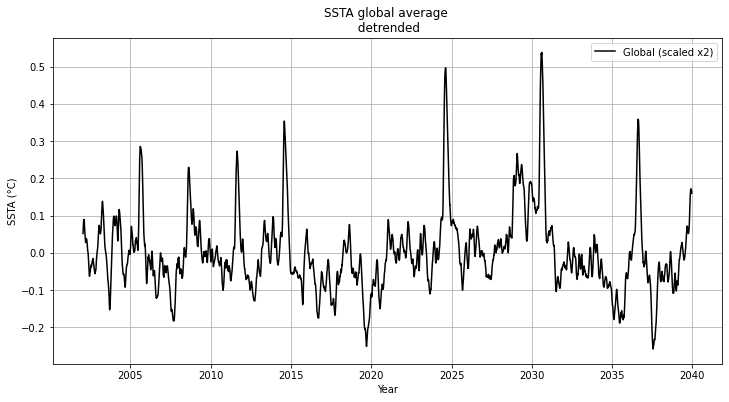

In [14]:

plt.figure(figsize=(12, 6))

# Smoothed data (black)
global_smooth = global_anom.rolling(time=30, center=True).mean()
plt.plot(ssta['time'], global_smooth, color='black', linewidth=1.5, label='Global (scaled x2)')

# Add other regions (NINO 3.4, NE Pacific, Gulf Stream, etc.)
plt.xlabel('Year')
plt.ylabel('SSTA (°C)')
plt.title('SSTA global average \n detrended')
plt.legend()
plt.grid(True)
plt.show()